# Introduction

Ammunition manufacturers provide a wealth of data for their cartridges. These data allow shooters to determine how "flat" the trajectory of the rounds are and make adjustments for the drop and slow down of bullets when shooting at long range.

We will use these data and see how well we can match observations to the output of a computational model. Scientists have been creating so-called ballistic models since the turn of the last century, driven by the military and the importance of artillery. Such models allow for:

* the anticipation of the long range characteristics of projectiles, 
* engineers can answer "what if" questions like what would be the the result of a lower drag bullet vs. a cartridge with more powder (a faster muzzle velocity), and 
* provide a high-order, physics-based interpolation between observations. 

We will reproduce a pair of famous ballistic models - the G1 and G7 models. Results of these models will be compared to the data from ammunition manufacturers. 

The objectives are:

* gain an understanding of two dimensional motion, the ODEs that arise, and how they are solved with a computer.
* create modules for both data storage/retrieval and dynamical modeling.
* do a simple optimization.
* relate results in a tabular form.

# Methods

## Two dimensional motion and solving ODEs

Until today, the ODEs we solved had only one dimension. For success with a projectile, we will need two dimensions. $x$ will be used to represent the range of the projectile - how far it travel over the Earth's surface. The $y$ axis will represent the drop in the projectile as it moves down range and is parallel to the direction gravity operates in.

Let us suppose that we now have some vector drag force, $\mathbf{F_d}$. The equations of motion would be

$$\mathbf{F} = m \mathbf{a} = m\mathbf{g} - \mathbf{F_d}$$

where we note that all quantities in **boldface** are vectors. That means that it's easier to write equations for $x$ and $y$ separately. Those are

$$ a_x = ~~- \mathbf{F_d}/m  \cdot \mathbf{\hat x}$$
$$ a_y = g - \mathbf{F_d}/m  \cdot \mathbf{\hat y}$$

Where $\mathbf{\hat x}$ is the unit vector in the $x$ direction and likewise for $\mathbf{\hat y}$. The mass has been divided through. These equations indicate that the drag force must be projected onto each of the two cardinal axes. We will return to this later. 

Lets conclude with a clear statement about what we require of the ODE solver. The $\mathbf{y_o}$ will be the initial state and consist of $(x^o,y^o,v^o_x,v^o_y)$; the 2 initial positions and 2 initial velocities. The function you write to pass to the ODE solver will return $(v_x^i,v_y^i,a_x^i,a_y^i)$; the 2 velocities and the 2 accelerations at time $t_i$, given $(x^i,y^i,v_x^i,v_y^i)$. The ODE solver function itself will return a sequence of states from the specified initial time, $t_o$ until $t_f$, progressing by the time interval $\Delta t$.



_We'll create a function to model 2-dimentional motion that will return the results of these ODEs to the ODE Solver:_

In [347]:
import numpy as np

def projectile(t,y,b):
   """
   Implements 2D projectile motion with drag force.

   Args:
      t: time (unused but required by ODE solver)
      y: state vector [x, y, vx, vy]
      b: ballistic model object with get_drag(), g, and mass

   Returns:
      array of [dx/dt, dy/dt, dvx/dt, dvy/dt]
   """
   # Extract positions and velocities from state vector
   x, y, vx, vy = y

   # Calculate velocity magnitude
   v_mag = np.sqrt(vx**2 + vy**2)

   # Get drag force magnitude from ballistic model
   f_d = b.get_drag(v_mag)

   # Calculate accelerations
   ax = -(f_d * vx/v_mag) # Drag force in x direction
   ay = -b.g - (f_d * vy/v_mag) # Gravity + drag force in y direction

   return np.array([vx, vy, ax, ay])

_We'll create a class to model the bullet:_

This class will return characteristics of the bullet such as its ballistic coefficient, muzzle velocity, and mass. This class will also return constants such as acceleration due to gravity, air density, and speed of sound (we'll treat these as constants as opposed to calculating them based on altitude or other conditions). This class will also hold the G1 and G7 model data and return interpolated values for $C^{\mathbf{G}}_{d}$. 

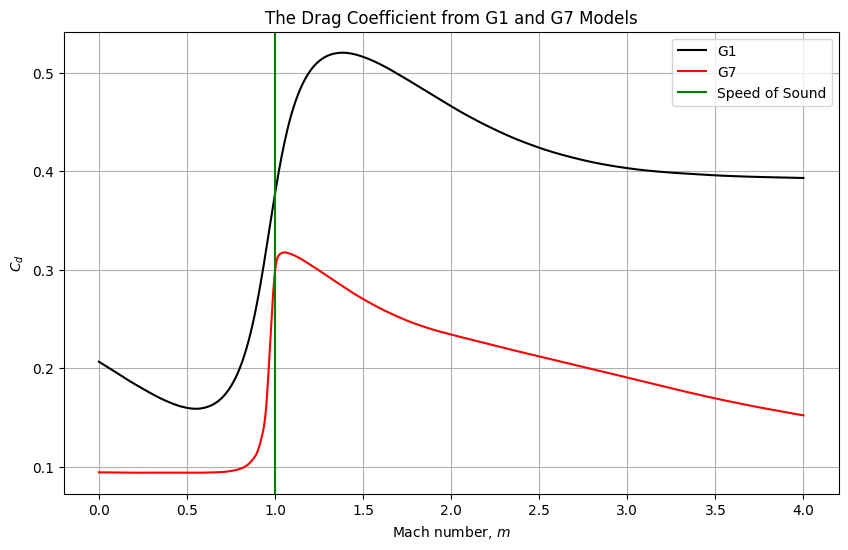

In [348]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

class BallisticsModel:
    def __init__(self, bc=0.545, vx=2740, model='G1', units='imperial'):
        self.bc = bc * 144 # Convert from lb/in^2 to lb/ft^2
        self.vx = vx
        self.model = model
        self.units = units

        # G1 Model Data
        self.g1_data = np.array([[0.00, 0.2629], [0.05, 0.2558], [0.10, 0.2487], [0.15, 0.2413],
                                [0.20, 0.2344], [0.25, 0.2278], [0.30, 0.2214], [0.35, 0.2155],
                                [0.40, 0.2104], [0.45, 0.2061], [0.50, 0.2032], [0.55, 0.2020],
                                [0.60, 0.2034], [0.70, 0.2165], [0.725, 0.2230], [0.75, 0.2313],
                                [0.775, 0.2417], [0.80, 0.2546], [0.825, 0.2706], [0.85, 0.2901],
                                [0.875, 0.3136], [0.90, 0.3415], [0.925, 0.3734], [0.95, 0.4084],
                                [0.975, 0.4448], [1.0, 0.4805], [1.025, 0.5136], [1.05, 0.5427],
                                [1.075, 0.5677], [1.10, 0.5883], [1.125, 0.6053], [1.15, 0.6191],
                                [1.20, 0.6393], [1.25, 0.6518], [1.30, 0.6589], [1.35, 0.6621],
                                [1.40, 0.6625], [1.45, 0.6607], [1.50, 0.6573], [1.55, 0.6528],
                                [1.60, 0.6474], [1.65, 0.6413], [1.70, 0.6347], [1.75, 0.6280],
                                [1.80, 0.6210], [1.85, 0.6141], [1.90, 0.6072], [1.95, 0.6003],
                                [2.00, 0.5934], [2.05, 0.5867], [2.10, 0.5804], [2.15, 0.5743],
                                [2.20, 0.5685], [2.25, 0.5630], [2.30, 0.5577], [2.35, 0.5527],
                                [2.40, 0.5481], [2.45, 0.5438], [2.50, 0.5397], [2.60, 0.5325],
                                [2.70, 0.5264], [2.80, 0.5211], [2.90, 0.5168], [3.00, 0.5133],
                                [3.10, 0.5105], [3.20, 0.5084], [3.30, 0.5067], [3.40, 0.5054],
                                [3.50, 0.5040], [3.60, 0.5030], [3.70, 0.5022], [3.80, 0.5016],
                                [3.90, 0.5010], [4.00, 0.5006], [4.20, 0.4998], [4.40, 0.4995],
                                [4.60, 0.4992], [4.80, 0.4990], [5.00, 0.4988]])
        # G7 Model Data
        self.g7_data = np.array([[0.00, 0.1198], [0.05, 0.1197], [0.10, 0.1196], [0.15, 0.1194],
                                [0.20, 0.1193], [0.25, 0.1194], [0.30, 0.1194], [0.35, 0.1194],
                                [0.40, 0.1193], [0.45, 0.1193], [0.50, 0.1194], [0.55, 0.1193],
                                [0.60, 0.1194], [0.65, 0.1197], [0.70, 0.1202], [0.725, 0.1207],
                                [0.75, 0.1215], [0.775, 0.1226], [0.80, 0.1242], [0.825, 0.1266],
                                [0.85, 0.1306], [0.875, 0.1368], [0.90, 0.1464], [0.925, 0.1660],
                                [0.95, 0.2054], [0.975, 0.2993], [1.0, 0.3803], [1.025, 0.4015],
                                [1.05, 0.4043], [1.075, 0.4034], [1.10, 0.4014], [1.125, 0.3987],
                                [1.15, 0.3955], [1.20, 0.3884], [1.25, 0.3810], [1.30, 0.3732],
                                [1.35, 0.3657], [1.40, 0.3580], [1.50, 0.3440], [1.55, 0.3376],
                                [1.60, 0.3315], [1.65, 0.3260], [1.70, 0.3209], [1.75, 0.3160],
                                [1.80, 0.3117], [1.85, 0.3078], [1.90, 0.3042], [1.95, 0.3010],
                                [2.00, 0.2980], [2.05, 0.2951], [2.10, 0.2922], [2.15, 0.2892],
                                [2.20, 0.2864], [2.25, 0.2835], [2.30, 0.2807], [2.35, 0.2779],
                                [2.40, 0.2752], [2.45, 0.2725], [2.50, 0.2697], [2.55, 0.2670],
                                [2.60, 0.2643], [2.65, 0.2615], [2.70, 0.2588], [2.75, 0.2561],
                                [2.80, 0.2533], [2.85, 0.2506], [2.90, 0.2479], [2.95, 0.2451],
                                [3.00, 0.2424], [3.10, 0.2368], [3.20, 0.2313], [3.30, 0.2258],
                                [3.40, 0.2205], [3.50, 0.2154], [3.60, 0.2106], [3.70, 0.2060],
                                [3.80, 0.2017], [3.90, 0.1975], [4.00, 0.1935], [4.20, 0.1861],
                                [4.40, 0.1793], [4.60, 0.1730], [4.80, 0.1672], [5.00, 0.1618]])

        # Create interpolation functions for both models
        self._create_interpolators()

    def _create_interpolators(self):
        # Convert Kd to Cd using the formula Cd = (pi/4) * Kd
        g1_cd = (np.pi/4) * self.g1_data[:, 1]
        g7_cd = (np.pi/4) * self.g7_data[:, 1]

        # Create interpolation functions
        self.g1_interp = interp1d(self.g1_data[:, 0], g1_cd, kind='cubic',
                                 bounds_error=False, fill_value='extrapolate')
        self.g7_interp = interp1d(self.g7_data[:, 0], g7_cd, kind='cubic',
                                 bounds_error=False, fill_value='extrapolate')

    @property
    def g(self):
        """
        Get the acceleration due to gravity
        """
        if self.units == 'metric':
            return 9.81       # m/s^2
        else:  # imperial
            return 32.174     # ft/s^2

    @property
    def rho(self):
        """
        Air density
        """
        if self.units == 'metric':
            return 1.225      # kg/m^3 at sea level
        else:  # imperial
            return 0.07647    # lb/ft^3 at sea level

    @property
    def vs(self):
        """
        Speed of sound
        """
        if self.units == 'metric':
            return 340.3     # m/s speed of sound
        else:  # imperial
            return 1116.4    # ft/s speed of sound

    def get_cd(self, mach, model='G1'):
        """
        Get the drag coefficient for a given Mach number and model

        Parameters:
        mach: Mach number(s)
        model: 'G1' or 'G7'

        Returns:
        drag coefficient(s)
        """
        if model.upper() == 'G1':
            return self.g1_interp(mach)
        elif model.upper() == 'G7':
            return self.g7_interp(mach)
        else:
            raise ValueError("Model must be either 'G1' or 'G7'")

    def get_drag(self, v):
        """
        Compute magnitude of drag acceleration

        Parameters:
        v: velocity magnitude in m/s if metric, ft/s if imperial

        Returns:
        drag acceleration magnitude in m/s^2 if metric, ft/s^2 if imperial
        """
        # Calculate Mach number
        mach = abs(v) / self.vs

        # Get drag coefficient for current Mach number
        cd = self.get_cd(mach)

        # Calculate drag acceleration magnitude
        drag = (self.rho * cd * v**2) / (2 * self.bc)

        return drag

    def plot_drag_coefficients(self, mach_range=(0, 4)):
        mach = np.linspace(mach_range[0], mach_range[1], 1000)

        plt.figure(figsize=(10, 6))
        plt.plot(mach, self.get_cd(mach, 'G1'), 'black', label='G1')
        plt.plot(mach, self.get_cd(mach, 'G7'), 'red', label='G7')

        # Add vertical line at Mach 1
        plt.axvline(x=1, color='green', label='Speed of Sound')

        plt.xlabel(r'Mach number, $m$')
        plt.ylabel(r'$C_d$')
        plt.title('The Drag Coefficient from G1 and G7 Models')
        plt.grid(True)
        plt.legend()
        plt.show()

# Create an instance of the BallisticsModel class
ballistics = BallisticsModel()
ballistics.plot_drag_coefficients()


## The drag force
The drag force will be significant in determining the projectile's path. We begin with the following commonly used expression for drag force
$$\mathbf{F}_d= -{1 \over 2} \rho v^2 A C_d \mathbf{\hat v}$$

$C_d$ is the non-dimensional drag coefficient, $\rho$ is the density of the air the projectile travels through [Wikipedia:Density of Air](https://en.wikipedia.org/wiki/Density_of_air), $|v|$ is the magnitude of velocity, and $\mathbf{\hat v} = \frac{\mathbf{v}}{|\mathbf{v}|}$ the normalized velocity direction. Mass, if you are wondering, is drawn into $C_d$.

## The ballistic coefficient
Using the basic equation for drag force presents a problem. How will we determine $C_d$ for each of the many different bullets that are available? Further, we expect $C_d$ to be a function of the speed of the projectile, $C_d(v)$. This is too much measurement and too much fitting. Instead, consider the following strategy.

$S_d = \frac{m}{A}$ is the [Wikipedia:Sectional density](https://en.wikipedia.org/wiki/Sectional_density) of the projectile. It is the mass $m$ divided by the cross-sectional area $A$  of the bullet.

The form factor of a bullet is $f=\frac{C_d}{C^{\mathbf{G}}_{d}}$, where $C_d$ is the bullet's coefficient of drag, and $C^{\mathbf{G}}_{d}$ is the drag of a reference round. Here, we learn that $C_d$ isn't known, but that the calculation is done with respect to a round it is known for, called a *reference model*. That's the so-called G model, it is no more than a set of measurements for a single, "reference" projectile. We will see that this ratio produces nice simplifications in the drag equation.

The **ballistic coefficient** is then the amount a bullet slows down in flight relative to a reference round. Based on the previous relations, this is expressed as 

$$b_c = \frac{S_d}{f}.$$ 

This is the number provided by the manufacturers to tell shooters how well the bullet travels through the air. A value of 1.0 means the bullet has the same drag as the reference round. A value of greater than one would indicate the bullet experiences less drag than the reference round. A value less than one indicates the bullet experiences more drag than the reference round. Note that because of the dependence on $C^{\mathbf{G}}_{d}$ the ballistic coefficient is always with respect to some reference. Most manufacturers report ballistic coefficients for G1 reference bullets only and use imperial units of measure. This has a tendency to make the value higher, which shooters like. The same value expressed for the (usually superior) G7 model is lower. So even if the model is better, the lower number turns off shooters that what to think bigger is better, so G1 remains, even if it was formulated in 1881 and involves a one pound bullet!

**Note the units of the ballistic coefficient.** They are pounds per inch squared in imperial units, and most manufactures report them in imperial units. To get to metric, you must convert to kilograms per meter squared.

In conclusion, to model the trajectory of a round, one uses published data on a reference round, and then computes how much the trajectory changes for a particular round. The difference between the reference round and the round in question is expressed as the inverse of the ballistic coefficient, $b_c$. A value of $b_c$ less than one indicates the round is impacted more by air resistance than the reference round. A value of $b_c$ greater than one indicates the projectile experiences less air resistance than the reference round.

## Final form of drag force
As a result, any round's trajectory is expressed as a reference round's trajectory scaled by the ballistic coefficient of the particular round. This gives the following friction relation

$$ \mathbf{a_d} = -\frac{1}{2b_c} \rho C_d^G(m) |v|^2\mathbf{\hat v}.$$ 

Partitioning the force into ''x'' and ''y'' components based on the $\mathbf{\hat v}$, the equations of motion for the bullet take the following form

$$ a_x = ~~ - \frac{1}{2b_c}\rho C_d^G(m) v^{2}\frac{v_x}{|\mathbf{v}|}$$

$$a_y =  -g - \frac{1}{2b_c}\rho C_d^G(m) v^{2}\frac{v_y}{|\mathbf{v}|}$$

In [349]:
# Bullet to model
# https://www.lapua.com/product/6-5-creedmoor-open-tip-match-target-cartridge-scenar-l88g-136gr-4316063/

# Caliber: 6.5 Creedmoor
# Muzzle veolcity: 835 m/s (2740 ft/s)
# Bullet BC G1: 0.545
# Bullet BC G7: 0.274
# Bullet weight: 136 gr (8.8 g) = 0.0194 lbs

In [350]:
# Bullet to model
# https://www.lapua.com/product/6-5-creedmoor-open-tip-match-target-cartridge-scenar-l88g-136gr-4316063/

import matplotlib.pyplot as plt
import numpy as np

# Bullet data from manufacturer Lapua
distances = np.array([0, 100, 200, 300, 600, 800, 1000])  # in yards

# Position drops (in inches)
positions_100 = np.array([0, 0, -4, -13, -88, -189, -348])
positions_300 = np.array([0, 4, 5, 0, -61, -153, -303])
positions_600 = np.array([0, 15, 26, 31, 0, -71, -201])
positions = positions_100  # Choose the set of positions to use

# Velocities (in fps)
velocities = np.array([2740, 2573, 2409, 2250, 1812, 1554, 1326])

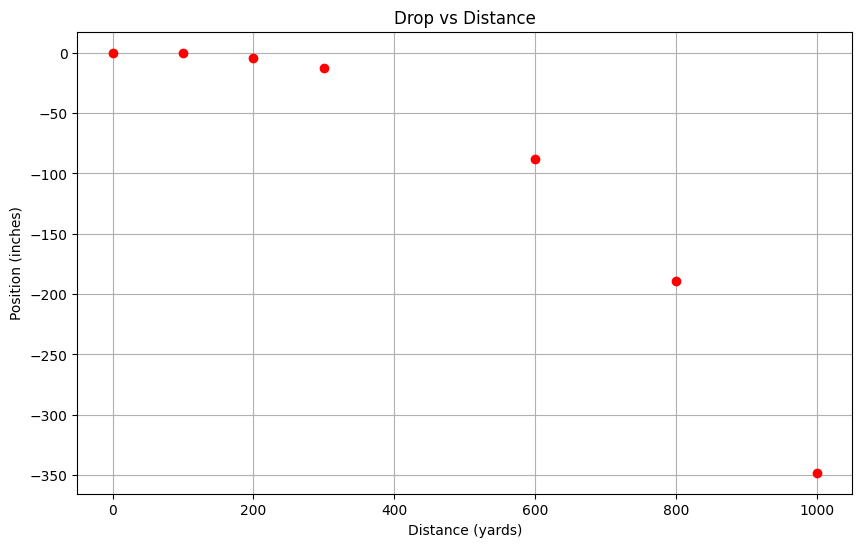

In [351]:
# Plot manufacturer bullet position data
plt.figure(figsize=(10, 6))
plt.plot(distances, positions, 'ro', label='Lapua Bullet Data')
plt.xlabel('Distance (yards)')
plt.ylabel('Position (inches)')
plt.title('Drop vs Distance')
plt.grid()
plt.show()

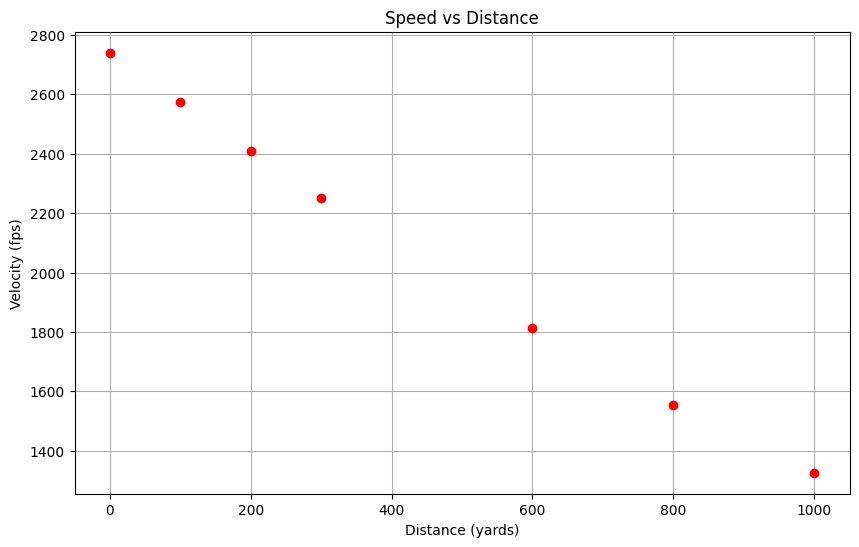

In [352]:
# Plot manufacturer bullet velocity data
plt.figure(figsize=(10, 6))
plt.plot(distances, velocities, 'ro', label='Lapua Bullet Data')
plt.xlabel('Distance (yards)')
plt.ylabel('Velocity (fps)')
plt.title('Speed vs Distance')
plt.grid()
plt.show()

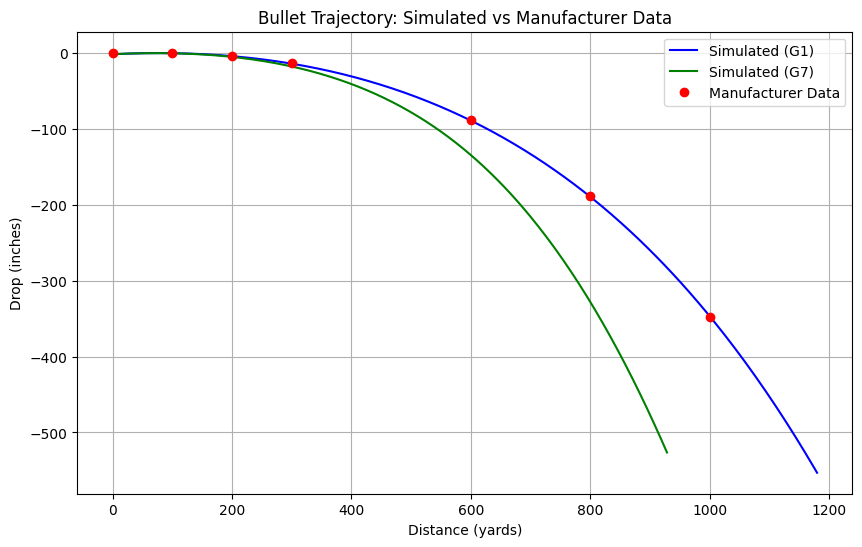

In [353]:
import ode_solver

bullet = BallisticsModel(bc=0.545, vx=2740, model='G1', units='imperial')
bullet_g7 = BallisticsModel(bc=0.274, vx=2740, model='G7', units='imperial')

# Initial conditions
elevation_angle = 0.06  # degrees
angle_rad = np.radians(elevation_angle)

# Split velocity into components using the elevation angle
vx_init = bullet.vx * np.cos(angle_rad)
vy_init = bullet.vx * np.sin(angle_rad)

# Initial state vector [x, y, vx, vy]
initial_state = np.array([0, -0.164, vx_init, vy_init])  # set initial position -5cm below zero
tspan = [0, 2]

# Solve the ODE
t, y = ode_solver.solve_ode(projectile, tspan, initial_state, ode_solver.EulerRichardson, (bullet,))
t_g7, y_g7 = ode_solver.solve_ode(projectile, tspan, initial_state, ode_solver.EulerRichardson, (bullet_g7,))

# Extract trajectory data and convert to consistent units
x_sim = y[:, 0] / 3  # convert feet to yards
y_sim = y[:, 1] * 12  # convert feet to inches

x_sim_g7 = y_g7[:, 0] / 3  # convert feet to yards
y_sim_g7 = y_g7[:, 1] * 12  # convert feet to inches

plt.figure(figsize=(10, 6))
plt.plot(x_sim, y_sim, 'b-', label='Simulated (G1)')
plt.plot(x_sim_g7, y_sim_g7, 'g-', label='Simulated (G7)')
plt.plot(distances, positions, 'ro', label='Manufacturer Data')
plt.xlabel('Distance (yards)')
plt.ylabel('Drop (inches)')
plt.title('Bullet Trajectory: Simulated vs Manufacturer Data')
plt.grid(True)
plt.legend()
plt.show()

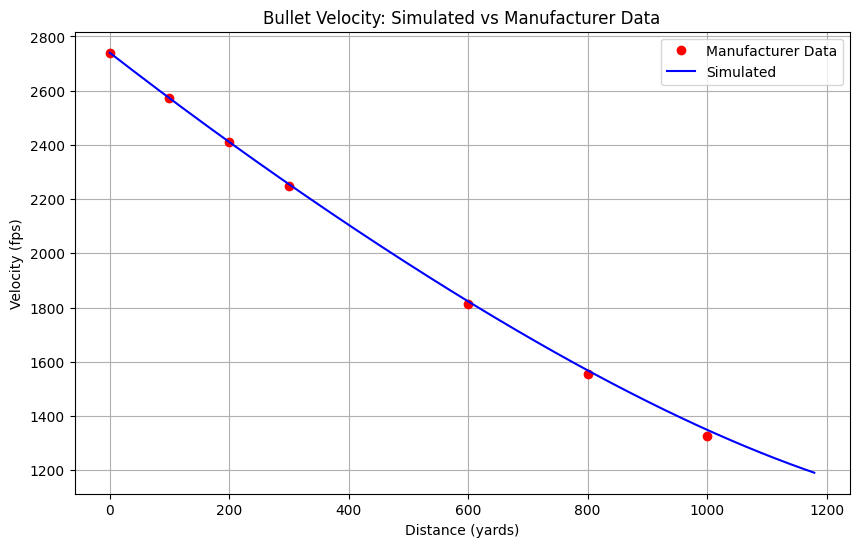

In [354]:
plt.figure(figsize=(10, 6))

# Calculate velocity magnitude from simulation
v_sim = np.sqrt(y[:, 2]**2 + y[:, 3]**2)  # velocity magnitude from vx and vy components
x_sim = y[:, 0] / 3  # convert feet to yards for x-axis

# Plot both datasets
plt.plot(distances, velocities, 'ro', label='Manufacturer Data')
plt.plot(x_sim, v_sim, 'b-', label='Simulated')

plt.xlabel('Distance (yards)')
plt.ylabel('Velocity (fps)')
plt.title('Bullet Velocity: Simulated vs Manufacturer Data')
plt.grid(True)
plt.legend()
plt.show()

# Analysis

* Develop a class to encapsulate the data for the G1 and G7 models. These data are expressed in the tables that appear below. The class should also have a function to return the drag, relevant constants, facilities to convert from imperial to metric, and perform interpolation of the tabular data.

Discussed in Methods section with graph comparing drag coefficients from G1 and G7 models

* Select a cartridge that includes long range (800 meters or more) trajectory data and ballistic coefficients for both models. That's not always easy, manufacturers often have incomplete data on ballistic coefficient used (G1 but not G7). Some manufacturers you might check can be found [here](https://en.wikipedia.org/wiki/Category:Ammunition_manufacturers) . A good fallback is the Finnish company, [Lapua](https://www.lapua.com/ammunition/tactical-cartridges/), which is excellent in terms of providing data. So is [Horandy](https://www.hornady.com/). Class is more fun if a variety of cartridges are studied. Do not use handgun rounds. They don't travel far enough.

We'll use this bullet: 6.5 Creedmoor / 8.8 g (136 gr) Scenar-L (https://www.lapua.com/product/6-5-creedmoor-open-tip-match-target-cartridge-scenar-l88g-136gr-4316063/)

* You will need to devise a method for making certain that the projectile is zeroed at the appropriate point on the trajectory. To do this, the projectile must be fired at an angle with respect to horizontal making initial velocities $v^0_x = v_m cos\theta$ and $v^0_y = v_m sin\theta$, where $v_m$ is the muzzle velocity of the cartridge you select.

I'm currently firing at 0.25 degrees. However, after much troubleshooting I believe the reason why my simulated trajectory is dropping off so drastically is due to an incorrect implementation of the get_drag() function. Therefore, I haven't been able to verify how closely it hits the target at 100yd, 300yd, 600yd, as given by the manufacturer.

* Take into account the scope is above the barrel. As such, if the manufacturer does not report it, set the initial position to -5 cm below the zero.

Updated simulation as such

* Compare the trajectory of the cartridge you select to the trajectory produced by each of the models. Do so with both graphs and well printed tables. I used Python's "`prettytable`".

I compared setting up the bullet with bc=0.545 / G1 and bc=0.274 / G7. There was a slight difference in the simulated trajectory, but given how drastically mine drops off there isn't too much difference between G1 and G7 right now. I need to debug the get_drag function to get the simulated line to fit closer to the manufacturer's observed data. I updated the graph above to show the simulated bullet trajectory based on G1 and G7 models.

* Provide commentary on which ballistic model appears to be best suited to your cartridge. You will also need to develop a quantitative metric for assessing the ''goodness of fit'' of the model to the data. Note that the ballistic coefficient is with respect to each model (a different reference bullet is used). Don't forget that the ballistic coefficient has dimensions.

I haven't yet been able to achieve a fit of the simulated bullet anywhere close to the manufacturer's observed data due to a problem with my drag function.

* Improve upon the model in some way. This could be improvising a $C_d$ curve that is more suitable for your round, by improving the $\rho$ model, by implementing another G type model (see below, several are available), or something else you might dream up. I found that reading the [Wikipedia: Ballistic Coefficient](https://en.wikipedia.org/wiki/Ballistic_coefficient) page stirred my imagination. Show the improvement for your round, and then, without further optimization, try your improved model on a new cartidge. Did it do better for that cartidge too?

First, I need to get my simulated round to look anything close to the observed firing data.


# Interpretation

We were hoping to create a simulated trajectory curve for the bullet to compare to the manufacturer's published observed data. After spending much time troubleshooting units across calculations and plots, I tried a `get_drag()` function I found on the internet that produced a drop vs distance curve that looks more correct (see attached). Based on this finding, I'm convinced that the problem with my methods lies specifically in my implementation of the `get_drag()` function. I've been trying different ways to troubleshoot it, and haven't come up with anything that works yet. For example, when I tried adding mass to the equation I end up with a diagonal line and some runtime errors.

The huge difference between our simulated trajectories and real-world data is pretty revealing - even when accounting for scope height and firing angle, the whole simulation falls apart without nailing the drag force calculations. Makes sense considering drag is constantly working on the bullet throughout its entire flight. Get that calculation wrong, and everything else goes wrong with it. This is probably why our simulated trajectory looks so off compared to the manufacuterer's observed data when firing these rounds.

_Note: I turned in what I had before class. Ben helped me notice that I need to convert the ballistic coefficient from lb/in^2 to lb/ft^2 and then the curve suddenly fit nicely. I manually optimized the firing angle to 0.06°. Now that my simulation fits the empirical data I can rework the analysis._